# Workshop MLENG Concept Drift - 25 min approx

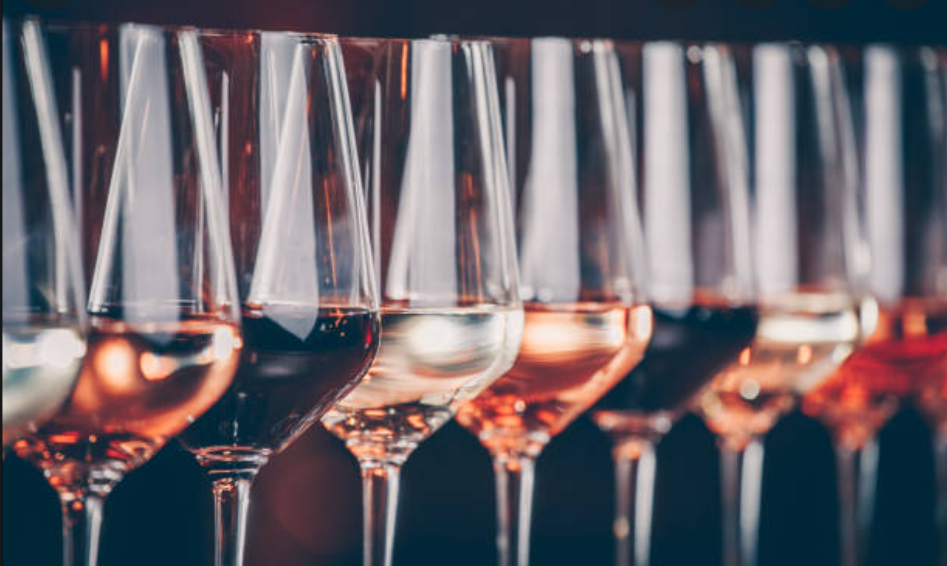

## Packages and Imports

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install --quiet seaborn numpy pandas river scikit-learn lightgbm matplotlib deepchecks evidently menelaus

In [ ]:
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import seaborn as sns

from mleng_workshop_drift import drift, drift_detector_with_labels, drift_detector_multivariate_hdddm, drift_detector_multivariate_md3, drift_detector_multivariate_ollindda, evidently_ai_detectors, deepcheck_detectors

plt.rcParams.update({'figure.figsize': (15, 7)})
plt.rcParams.update({'font.size': 20})
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Preparation of the Dataset

### Fetch red and white wine dataset

In [ ]:
red_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
white_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")

In [ ]:
red_wine_dataset['wine_type'] = "red"
white_wine_dataset['wine_type'] = "white"

In [ ]:
wine_dataset = pd.concat([red_wine_dataset, white_wine_dataset], axis=0)
wine_dataset["wine_type"] = np.where(wine_dataset["wine_type"] == "red", 1, 0)
wine_dataset.head()

### Classification problem with target variable named `quality` (0, 1, 2)

In [ ]:
conditions = [
    (wine_dataset["quality"] <= 3),
    (wine_dataset.quality > 3) & (wine_dataset.quality <= 6),
    (wine_dataset["quality"] > 6)
]

values = [0, 1, 2]

wine_dataset["quality"] = np.select(conditions, values)

wine_dataset["quality"].value_counts()

## Fit Light GBM

In [ ]:
wine_dataset_train, wine_dataset_test = train_test_split(wine_dataset, test_size=0.4, shuffle=True)
X_train = wine_dataset_train.loc[:, wine_dataset_train.columns != "quality"]
y_train = wine_dataset_train["quality"]
X_test = wine_dataset_test.loc[:, wine_dataset_test.columns != "quality"]
y_test = wine_dataset_test["quality"]

In [ ]:
categorical_features_names = ["wine_type"]
features_names = X_train.columns
cat_features_index = [index for index, feature_name in enumerate(features_names) if
                      feature_name in categorical_features_names]

In [ ]:
model_params = {
    'learning_rate': 0.1,
    'max_depth': None,
    'n_estimators': 500,
    'min_child_samples': 10,
    'categorical_feature': cat_features_index,
    'n_jobs': 1,
    'random_state': 1234,
}
lgbm_model = LGBMClassifier(**model_params)
lgbm_model.fit(X_train, y_train)

In [ ]:
y_pred = lgbm_model.predict(X_test)
acc = accuracy_score(y_pred, y_test)
print(f"Model Accuracy: {round(acc, 2)}")

## Induce Virtual Concept Drifts - 5 min

Check out the drifts file. Example to increase the chlorides values by 0.5:

```
wine_dataset_corrupted_chlorides = drift_generator_univariate_increase(data=wine_dataset_test,
                                                                       column_name="chlorides",
                                                                       value=0.5)
```

### Your turn: increase the Alcohol column by 2

In [ ]:
wine_dataset_test.columns

In [ ]:
# your code
# wine_dataset_corrupted_alcohol = <CODE HERE>

wine_dataset_corrupted_alcohol = drift.drift_generator_univariate_increase(data=wine_dataset_test,
                                                                           column_name='alcohol',
                                                                           value=2)

To check that you have correctly induced a drift:

In [ ]:
plt.hist(wine_dataset_corrupted_alcohol["alcohol"], label="corrupted dataset", bins=30, alpha=.7)
plt.hist(wine_dataset_test["alcohol"], label="original dataset", bins=30, alpha=.7)
plt.legend(loc="best")
plt.xlabel("alcohol")
plt.ylabel("# occurrences")
plt.show()

### Your turn: decrease the total sulfur dioxide variance by 100

In [ ]:
# your code
# wine_dataset_corrupted_dioxide = <CODE HERE>

sigma = (wine_dataset_test["total sulfur dioxide"].var() - 100)
mu = wine_dataset_test["total sulfur dioxide"].mean()
wine_dataset_corrupted_dioxide = drift.drift_generator_univariate_change_to_normal(data=wine_dataset_test,
                                                                                     column_name="total sulfur dioxide",
                                                                                     seed=202,
                                                                                     mu = mu,
                                                                                     sigma=sigma)

### Your turn: swap values of the wine_type column


In [ ]:
# your code
# wine_dataset_corrupted_wine_type = <CODE HERE>
wine_dataset_corrupted_wine_type = drift.drift_generator_univariate_categorical_change(data=wine_dataset_test, column_name='wine_type', value1="1",value2="0")

## Induce Real Concept Drifts - 5 min

In [ ]:
wine_corr = wine_dataset_test.corr()
wine_corr.style.background_gradient(cmap='coolwarm')

In [ ]:
sns.histplot(wine_dataset["chlorides"]);

Check out the drifts file. Example to change the wine quality to "good" when the chlorides values are higher than 0.1. (Look at the negative correlation and the distributions of chlorides in the previous plots!)

```
wine_dataset_corrupted = drift.drift_generator_concept_drift(
    data=dataset_sample,
    column_name="chlorides",
    value=0.1,
    label_col="quality",
    label_value=2,
    action="greater")
```

### Your turn: change wine quality to "bad" (0) when alcohol is greater than 12

In [ ]:
# Your code
# wine_dataset_corrupted_concept_drift = <CODE HERE>
wine_dataset_corrupted_concept_drift = drift.drift_generator_concept_drift(data=wine_dataset_test,
                                                                           column_name="alcohol",
                                                                           value=12,
                                                                           label_col="quality",
                                                                           label_value=0,
                                                                           action="greater")


You can check that the correlation has now changed!

In [ ]:
wine_dataset_test["alcohol"].corr(wine_dataset_test["quality"])

In [ ]:
wine_dataset_corrupted_concept_drift["alcohol"].corr(wine_dataset_corrupted_concept_drift["quality"])

## Test Univariate Detectors : Deepchecks - 5 min

Check out the deepcheck_detector file. 
Quick explanation of the functions:

*   deepcheck_detect_drift detects abrupt drifts
*   deepcheck_detect_gradual_drift detects gradual drifts
*   deepcheck_detect_seasonal_drift detects seasonal drifts

For each function, you can do three types of tests:


*   feature_drift to check for a change in a feature distribution
*   prediction_drift to check for a change in the predicted values
*   dataset_drift to check for a change in the entire dataset (if we can distinguish between the train and the test dataset) 

Example code:


```
deepcheck_detectors.deepcheck_detect_drift(wine_dataset_train,
                                           wine_dataset_corrupted_wine_type,
                                           label_col="quality",
                                           cat_features=categorical_features_names,
                                           model=lgbm_model,
                                           test_type="feature_drift")
```





### Your turn: check if one of your previous drifted dataset are detected with Deepcheck!

In [ ]:
# Your code
deepcheck_detectors.deepcheck_detect_drift(wine_dataset_train,
                                           wine_dataset_corrupted_wine_type,
                                           label_col="quality",
                                           cat_features=categorical_features_names,
                                           model=lgbm_model,
                                           test_type="feature_drift")

In [ ]:
deepcheck_detectors.deepcheck_detect_drift(wine_dataset_train,
                                           wine_dataset_corrupted_concept_drift,
                                           label_col="quality",
                                           cat_features=categorical_features_names,
                                           model=lgbm_model,
                                           test_type="dataset_drift")

## Test Multivariate Detectors: HDDDM - 5 min

Check out the HDDDM multivariate detector file. HDDDM is based on the Hellinger distance.

Quick explanation of the functions:

*   hdddm_detect_drift detects abrupt drifts
*   hdddm_detect_gradual_drift detects gradual drifts
*   hdddm_detect_seasonal_drift detects seasonal drifts

Example code:


```
drift_detector_multivariate_hdddm.hdddm_detect_drift(data_train=wine_dataset_train,
                                                     data_to_compare=wine_dataset_corrupted_sulphates,
                                                     gamma_level=0.05) 
```



### Your turn: check if one of your previous drifted dataset are detected with HDDDM!

In [ ]:
# Your code
drift_detector_multivariate_hdddm.hdddm_detect_drift(data_train=wine_dataset_train,
                                                     data_to_compare=wine_dataset_corrupted_dioxide,
                                                     gamma_level=0.05)

## Test Detectors with labels: HDDM_W - 5 min

HDDM is a labeled detection method based on Hoeffding's bounds. It is already implemented in the scikit-flow library. 

Because we will use the error rate, we will need a model to generate some predicted values and compare them with the true labels.

We will look for a **change in the error rate**, so we will work on both train and the test dataset!

Quick explanation of the functions:

*   drift_detector_with_labels_test detects abrupt drifts
*   drift_detector_labels_gradual_drift detects gradual drifts
*   drift_detector_labels_seasonal_drift detects seasonal drifts

Other labeled detectors:

*   EDDM
*   ADWIN
*   HDDM_W


Example code:


```
wine_data = pd.concat([wine_dataset_train, wine_dataset_corrupted_alcohol], axis=0)
drift_detector_with_labels.drift_detector_with_labels_test(data_to_compare=wine_data,
                                                           label_col="quality",
                                                           model=lgbm_model,
                                                           test_name="HDDM_W")
```


### Your turn: check if one of your previous drifted dataset are detected with HDDM_W!

Don't forget to merge your train and corrupted dataset before! 
Hint: check the example code

In [ ]:
# Your code
wine_data = pd.concat([wine_dataset_train, wine_dataset_corrupted_alcohol], axis=0)
drift_detector_with_labels.drift_detector_with_labels_test(data_to_compare=wine_data,
                                                           label_col="quality",
                                                           model=lgbm_model,
                                                           test_name="HDDM_W")

## Bonus: test a gradual drift of your choice with evidently AI

Example code to help you

```
evidently_ai_detectors.evidently_ai_detect_seasonal_drift(data_train=wine_dataset_train,
                                                          data_to_compare=wine_dataset_test,
                                                          label_col="quality",
                                                          cat_features=categorical_features_names,
                                                          nb_days=10,
                                                          nb_sample=100,
                                                          column_name="pH",
                                                          action="divide",
                                                          value_drift=1.2,
                                                          frequency=3)
                                                         ```

In [ ]:
# Your code
evidently_ai_detectors.evidently_ai_detect_seasonal_drift(data_train=wine_dataset_train,
                                                          data_to_compare=wine_dataset_test,
                                                          label_col="quality",
                                                          cat_features=categorical_features_names,
                                                          nb_days=10,
                                                          nb_sample=100,
                                                          column_name="pH",
                                                          action="divide",
                                                          value_drift=1.2,
                                                          frequency=3)

## Bonus 2: test a seasonal drift of your choice with MD3
Example code to help you

```
md3_seasonal_drift(data_train = wine_dataset_train,
                   data_to_compare = wine_dataset_test,
                   column_name= "alcohol",
                   label_col = "quality",
                   value_drift = 5,
                   frequency = 3,
                   action = "increase",
                   nb_sample = 100,
                   nb_days = 5)
```

In [ ]:
# Your code
drift_detector_multivariate_md3.md3_seasonal_drift(data_train=wine_dataset_train,
                                          data_to_compare=wine_dataset_test,
                                          column_name="alcohol",
                                          label_col="quality",
                                          value_drift=5,
                                          frequency=3,
                                          action="increase",
                                          nb_sample=100,
                                          nb_days=5)